In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

#models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error


from sklearn.preprocessing import StandardScaler

from helper import *

In [78]:
numeric_df = pd.read_csv('../data/train.csv')
#numeric_df.head()

In [79]:
#numeric_df.drop(['Id'], axis=1, inplace=True)
#numeric_df.info()

In [80]:
numeric_df = numeric_df.select_dtypes(include=[np.number])
print(numeric_df.columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [81]:
count_nulls(numeric_df)

,nulls,percent_missing
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479


## Estimating LotFrontage
fill in NA values

In [82]:
LotFrontage_numeric_df = numeric_df.dropna(subset=['LotFrontage'])
LotFrontage_numeric_df.corr()['LotFrontage'].sort_values(ascending=False)[0:6]

LotFrontage     1.000000
1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
Name: LotFrontage, dtype: float64

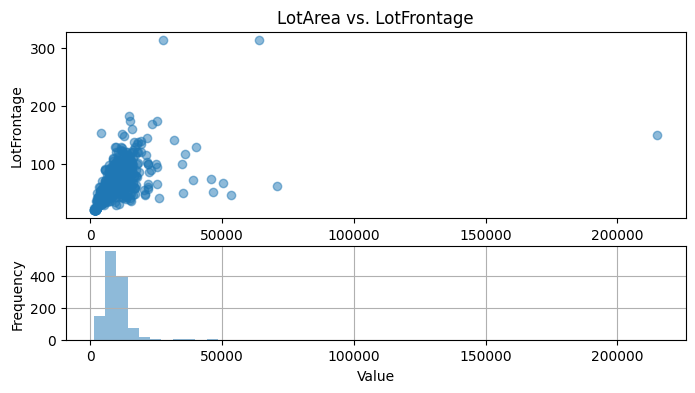

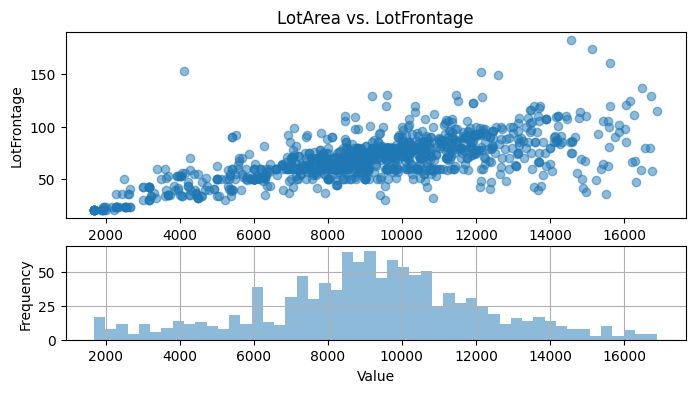

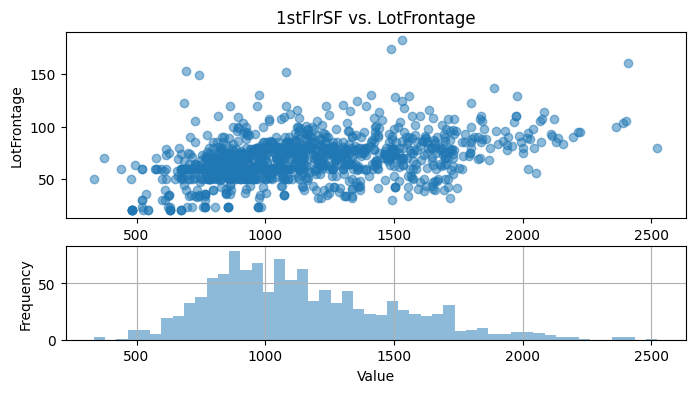

In [83]:
ajr_plot_scatter_volume(LotFrontage_numeric_df, 'LotArea', 'LotFrontage', fig_height=8)

def iqf(data: pd.DataFrame, column: str) -> pd.DataFrame:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] > lower_bound) & (data[column] < upper_bound)]

LotFrontage_numeric_df = iqf(LotFrontage_numeric_df, 'LotArea')

ajr_plot_scatter_volume(LotFrontage_numeric_df, 'LotArea', 'LotFrontage', fig_height=8)
ajr_plot_scatter_volume(LotFrontage_numeric_df, '1stFlrSF', 'LotFrontage', fig_height=8)
#ajr_plot_scatter_volume(LotFrontage_numeric_df, 'GrLivArea', 'LotFrontage', fig_height=8)
#ajr_plot_scatter_volume(LotFrontage_numeric_df, 'TotalBsmtSF', 'LotFrontage', fig_height=8)

In [84]:
LotFrontage_top_features = numeric_df.corr()['LotFrontage'].sort_values(ascending=False)[1:5].index.to_list()
LotFrontage_top_features

['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF']

In [85]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), GradientBoostingRegressor(), AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(), SVR()]

scores = {}
for i in tqdm(range(20)):
    for model in models:
        X = LotFrontage_numeric_df[['LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF']]
        y = LotFrontage_numeric_df['LotFrontage']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        if model in scores:
            scores[model].append(score)
        else:
            scores[model] = [score]

# Calculate the mean score for each model
mean_scores = {model: np.mean(score_list) for model, score_list in scores.items()}

# Find the model with the highest mean score
best_model = max(mean_scores, key=mean_scores.get)

# Print the mean scores for each model
for model, mean_score in mean_scores.items():
    print(f'{model}: {mean_score}')

best_model, mean_scores[best_model]

100%|██████████| 20/20 [00:05<00:00,  3.45it/s]

LinearRegression(): 0.5215403691414735
Ridge(): 0.5215403691612363
Lasso(): 0.5215384477643406
ElasticNet(): 0.5215394117594159
GradientBoostingRegressor(): 0.5214765690582416
AdaBoostRegressor(): 0.39518149256781043
BaggingRegressor(): 0.4793347653171719
ExtraTreesRegressor(): 0.4966403481405693
DecisionTreeRegressor(): 0.3105669862628352
KNeighborsRegressor(): 0.39728698761587217
SVR(): 0.5220860165997548


(SVR(), np.float64(0.5220860165997548))

In [86]:
lot_frontage_model = SVR()
X = LotFrontage_numeric_df[['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF']]
y = LotFrontage_numeric_df['LotFrontage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lot_frontage_model.fit(X_train, y_train)
y_pred = lot_frontage_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R2: {r2}')
print(f'MSE: {mse}')

R2: 0.522086016599755
MSE: 197.87366806808257


In [87]:
missing_lotfrontage_indices = numeric_df[numeric_df['LotFrontage'].isnull()].index
missing_features = numeric_df.loc[missing_lotfrontage_indices, ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF']]
predicted_lotfrontage = lot_frontage_model.predict(missing_features)
numeric_df.loc[missing_lotfrontage_indices,'LotFrontage'] = predicted_lotfrontage

Tested with various regression models and combinations of features to predict LotFrontage.

LotFrontage is the linear feet of street connected to the property. It is a continuous variable. It is reasonable to assume that the LotFrontage of a property is related to the LotArea of the property. We can use this relationship to estimate the LotFrontage of properties with missing values.

GarageYrBlt is null because they don't have a garage. We can replace these null values with 0.

In [88]:
count_nulls(numeric_df)

,nulls,percent_missing
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479


## MasVnrArea
fill in NA values. These null values are due to the fact that the property does not have a veneer, leading to null values. No veneer also means square footage of veneer is 0, which is why we can replace these null values with 0.

In [89]:
numeric_df['MasVnrArea'] = numeric_df['MasVnrArea'].fillna(0)
numeric_df['GarageYrBlt'] = numeric_df['GarageYrBlt'].fillna(0)

count_nulls(numeric_df)

,nulls,percent_missing


In [90]:
numeric_df.to_csv('../new_data/clean_train_numeric.csv', index=False)

## GarageYrBlt
These null values are due to the fact that the property does not have a garage, leading to null values. 
There is no reasonable replacement since the year the garage was built is not available. These rows must be dropped for regression but kept for other classification models.

In [91]:
#numeric_df = numeric_df.dropna(subset=['GarageYrBlt'])

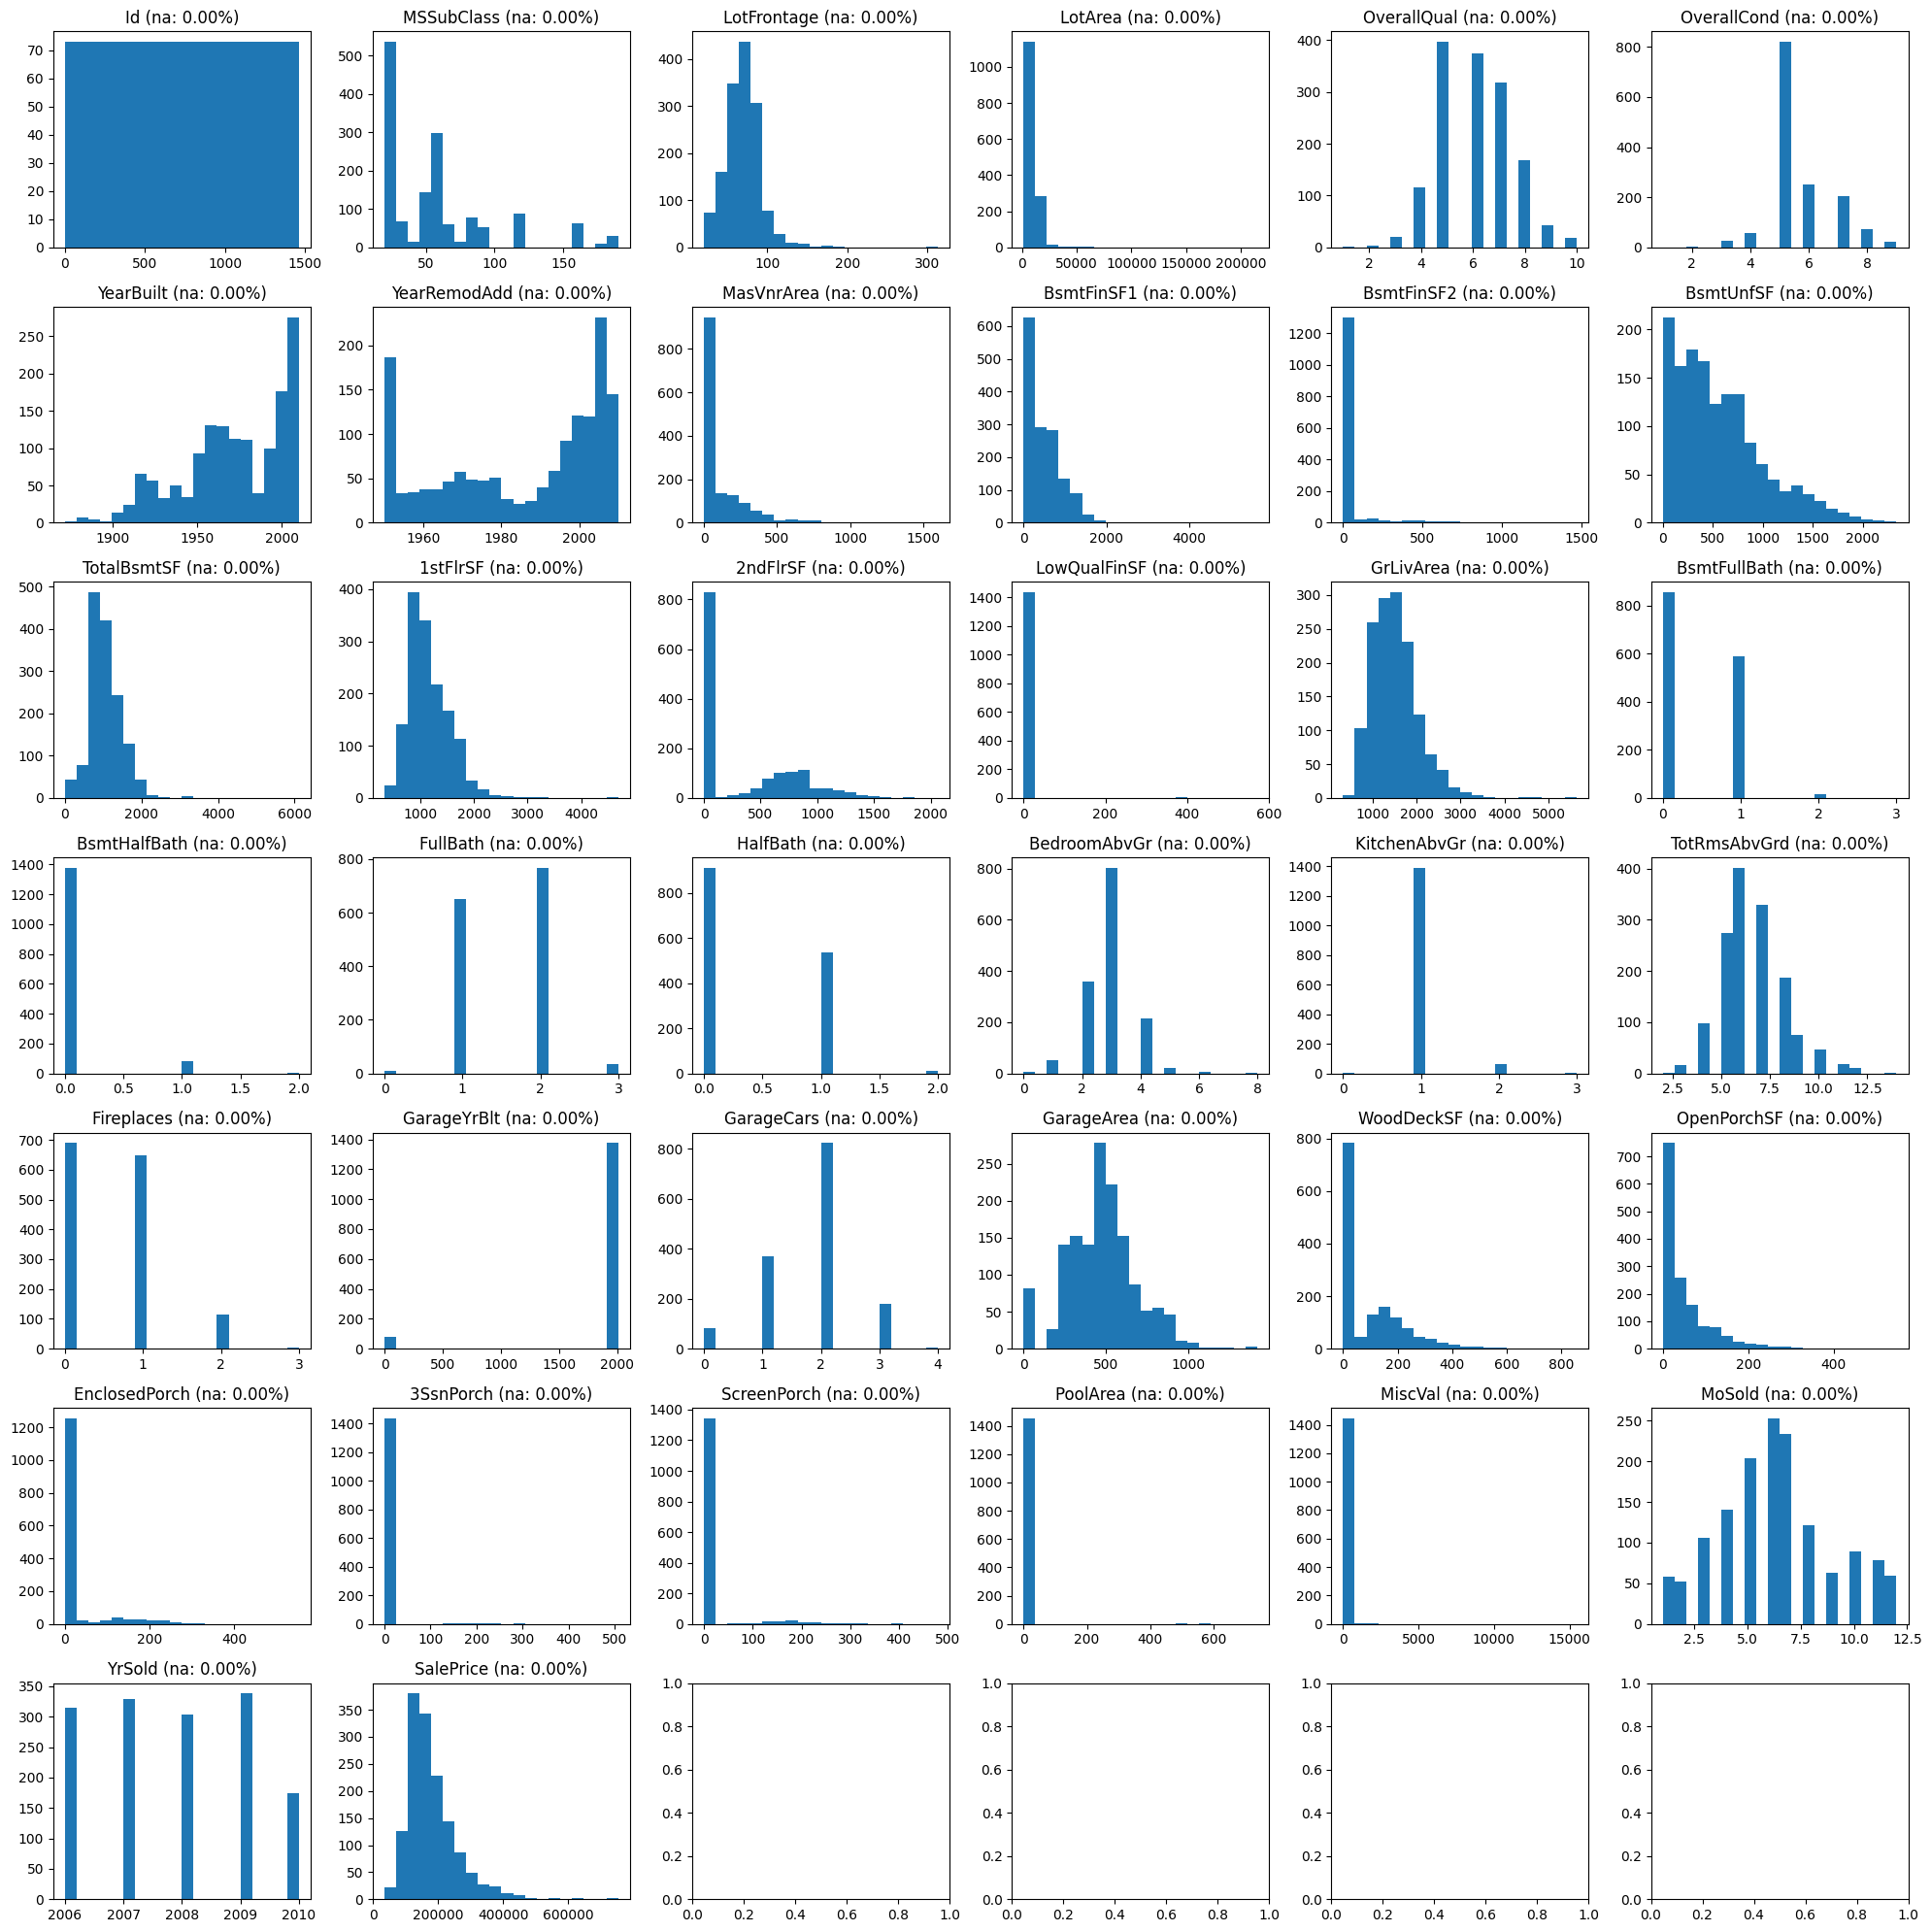

In [92]:
ajr_plot_histograms(numeric_df)

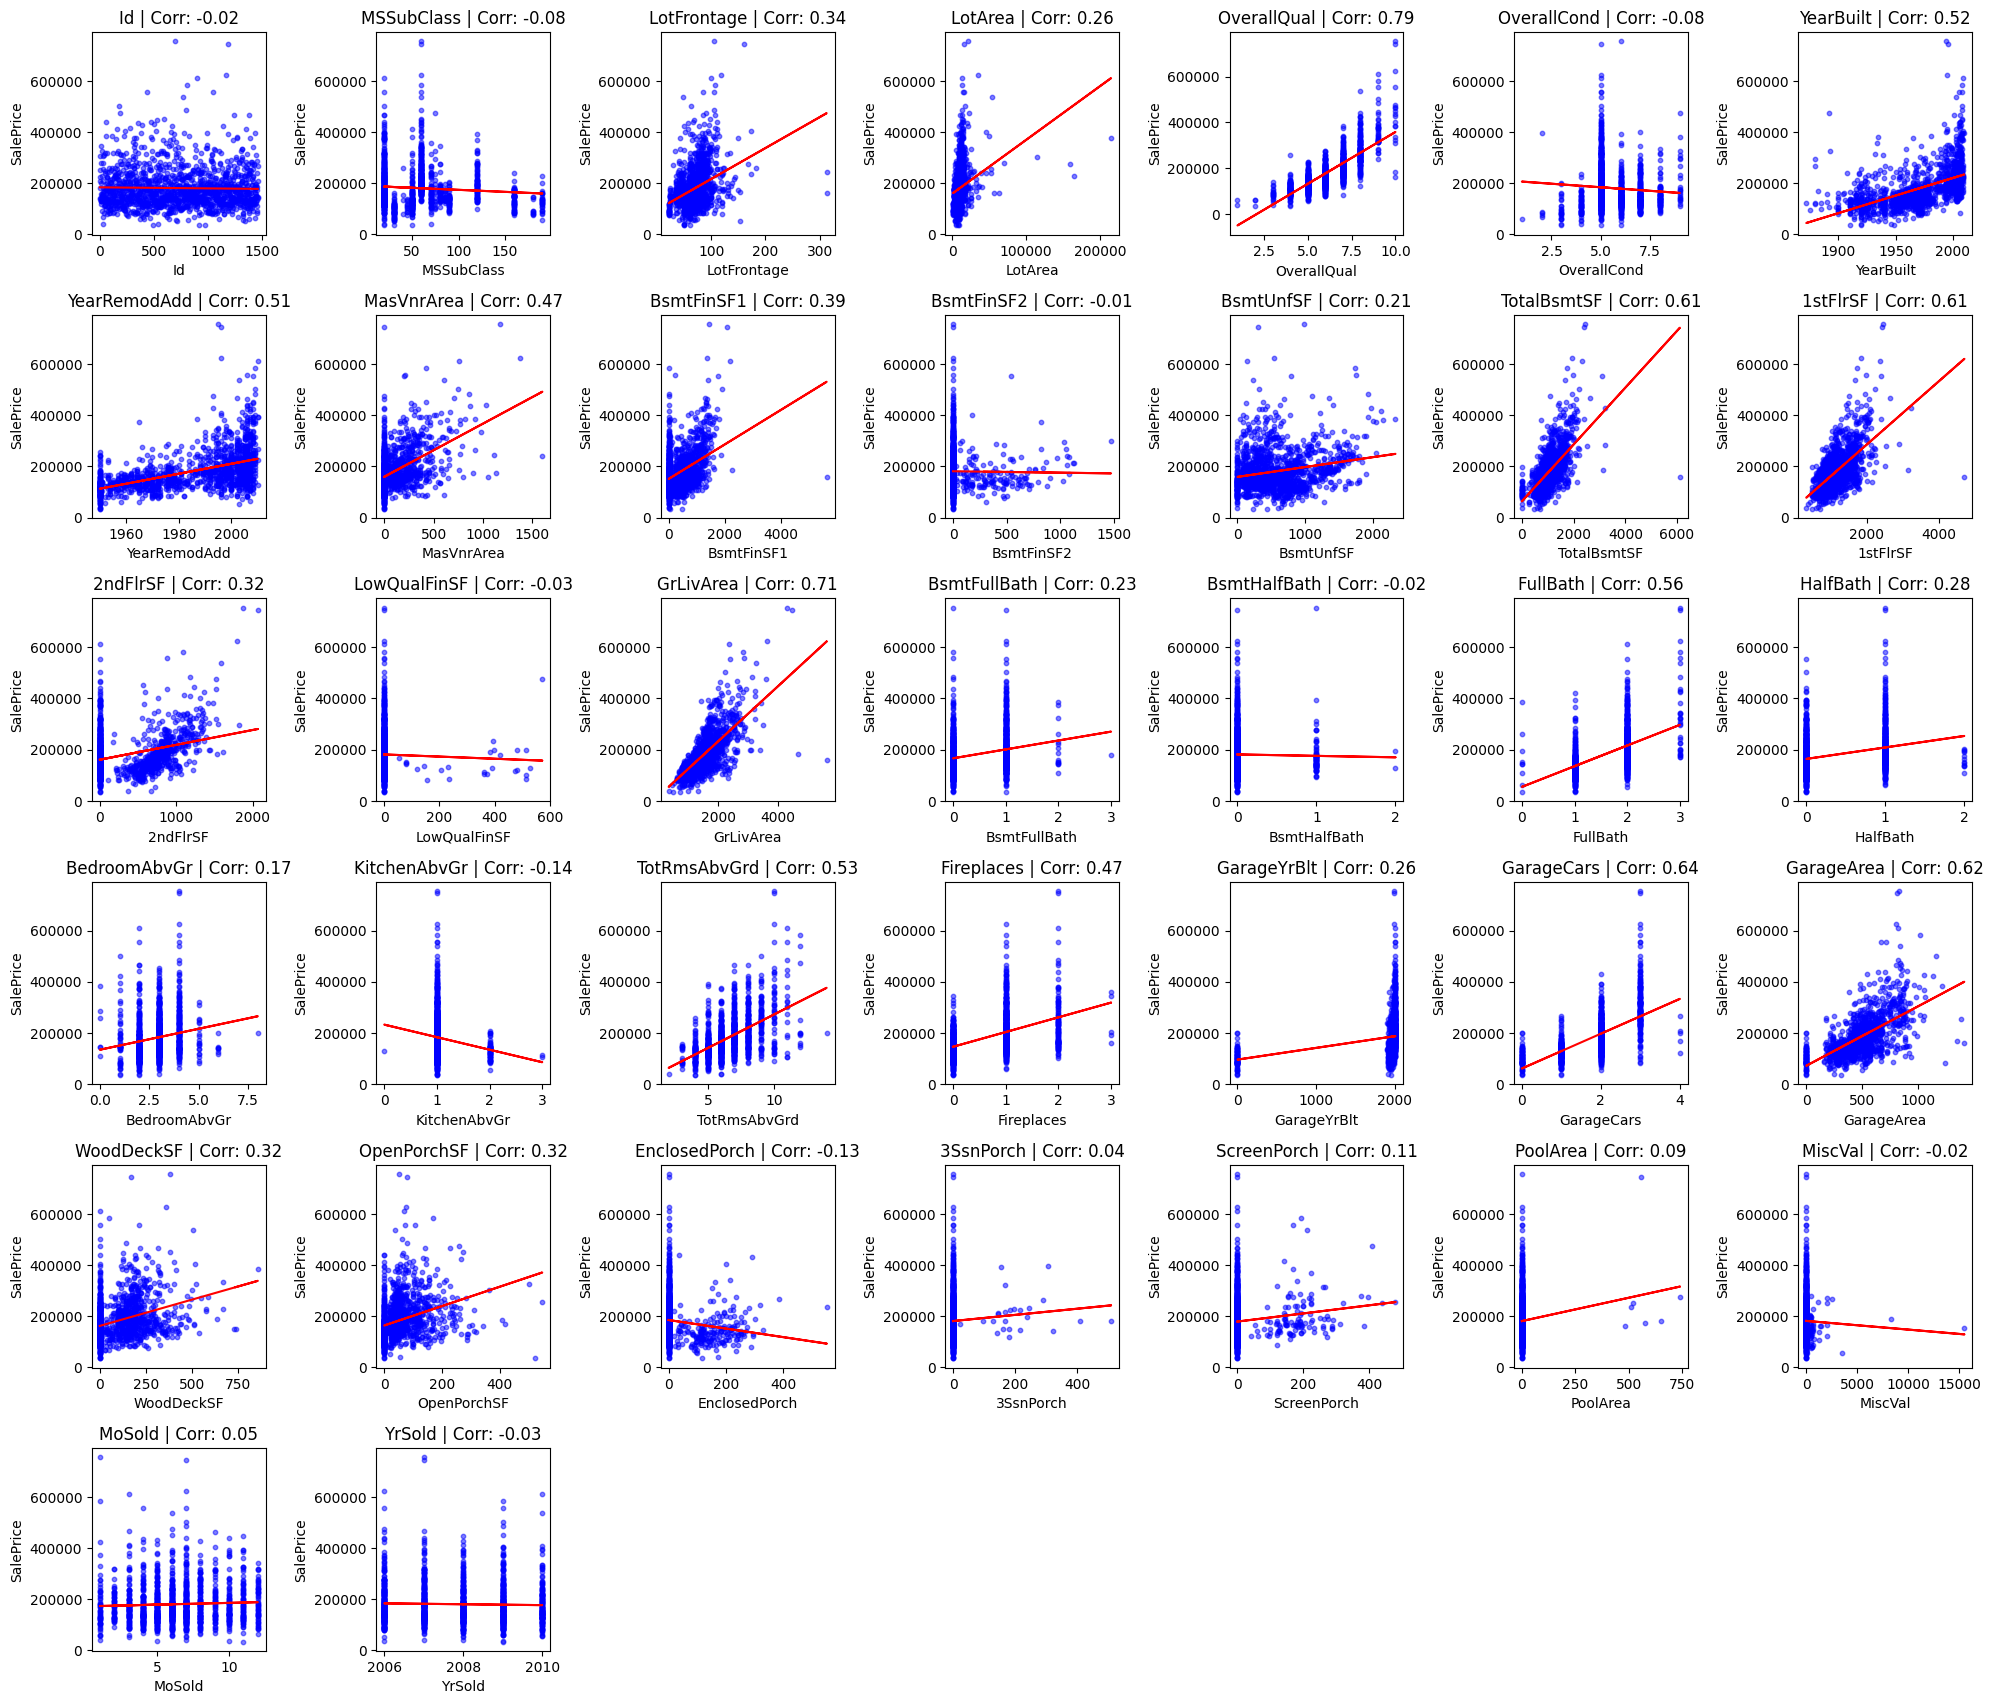

In [93]:
ajr_plot_correlations(numeric_df, 'SalePrice')

/tmp/ipykernel_129075/104637676.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


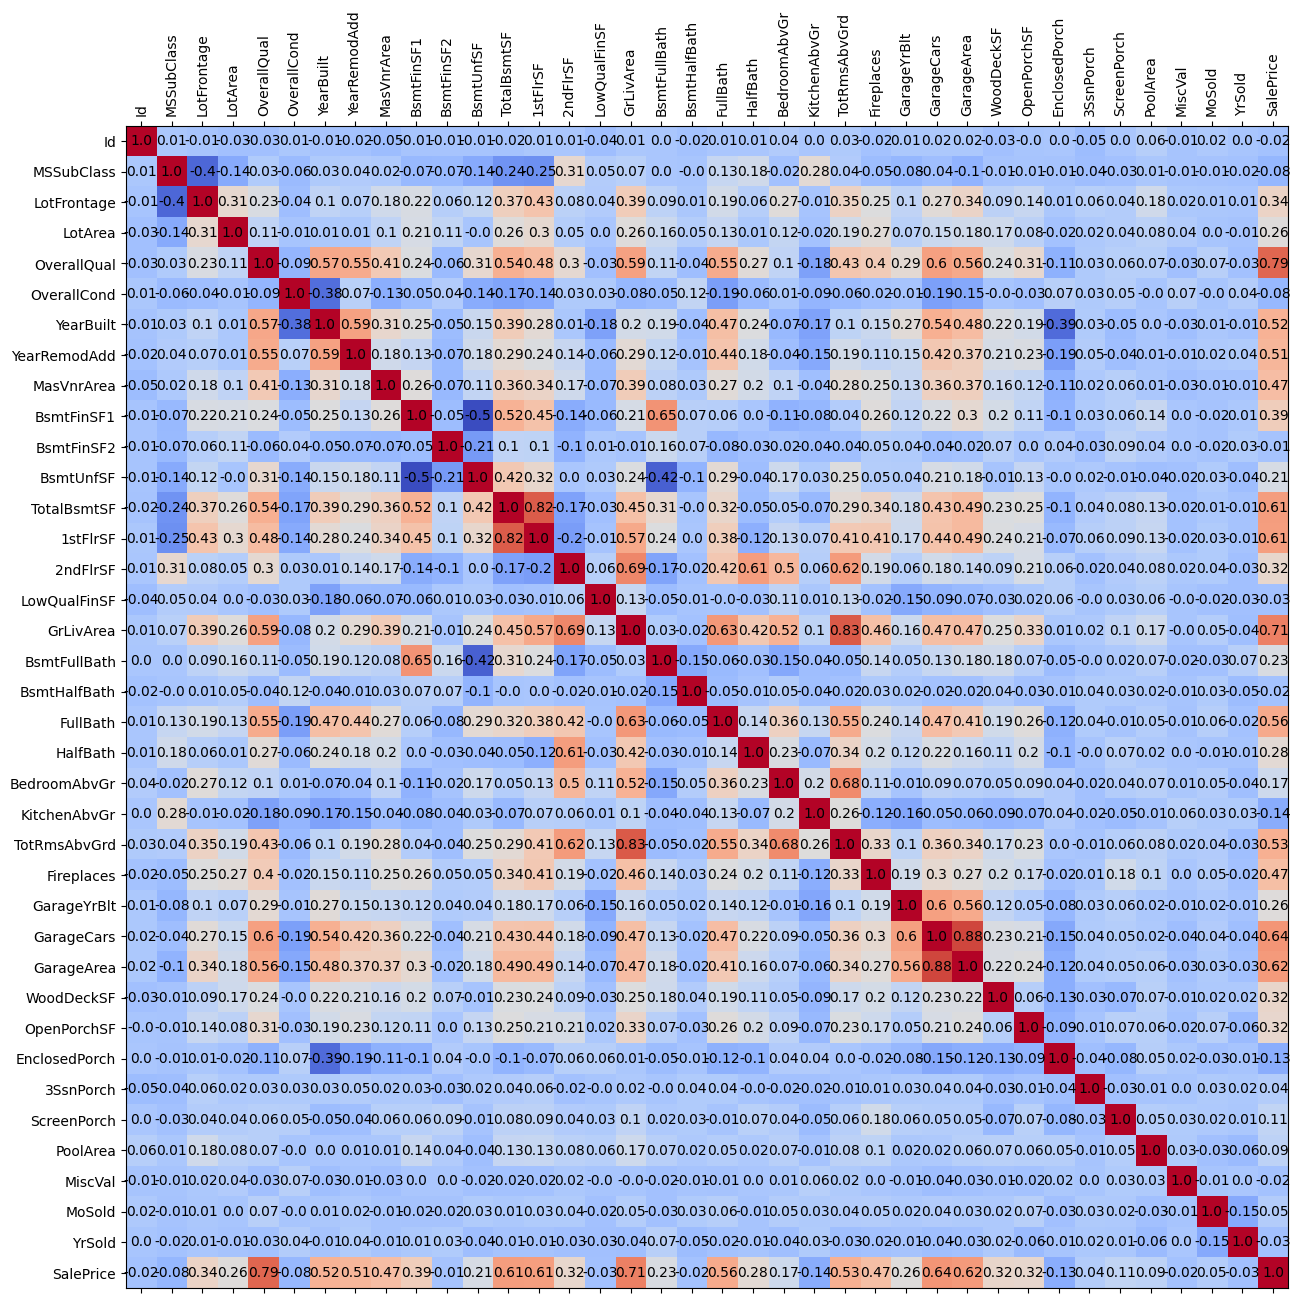

In [94]:
numeric_corr = numeric_df.corr()

def ajr_correlation_plot(corr_numeric_df, fig_height=10):
    column_names = list(corr_numeric_df.columns.values)
    plt.figure(figsize=(fig_height, fig_height))
    plt.matshow(corr_numeric_df, cmap='coolwarm', fignum=1)
    plt.xticks(np.arange(len(column_names)), column_names, rotation=90)
    plt.yticks(np.arange(len(column_names)), column_names)
    plt.tight_layout()
    
    for i in range(len(corr_numeric_df.columns)):
        for j in range(len(corr_numeric_df.columns)):
            plt.text(j, i, f'{round(corr_numeric_df.iloc[i, j], 2)}', ha='center', va='center', color='black')

ajr_correlation_plot(numeric_corr, fig_height=15)

## Creating a model using numerical only features

/tmp/ipykernel_129075/104637676.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


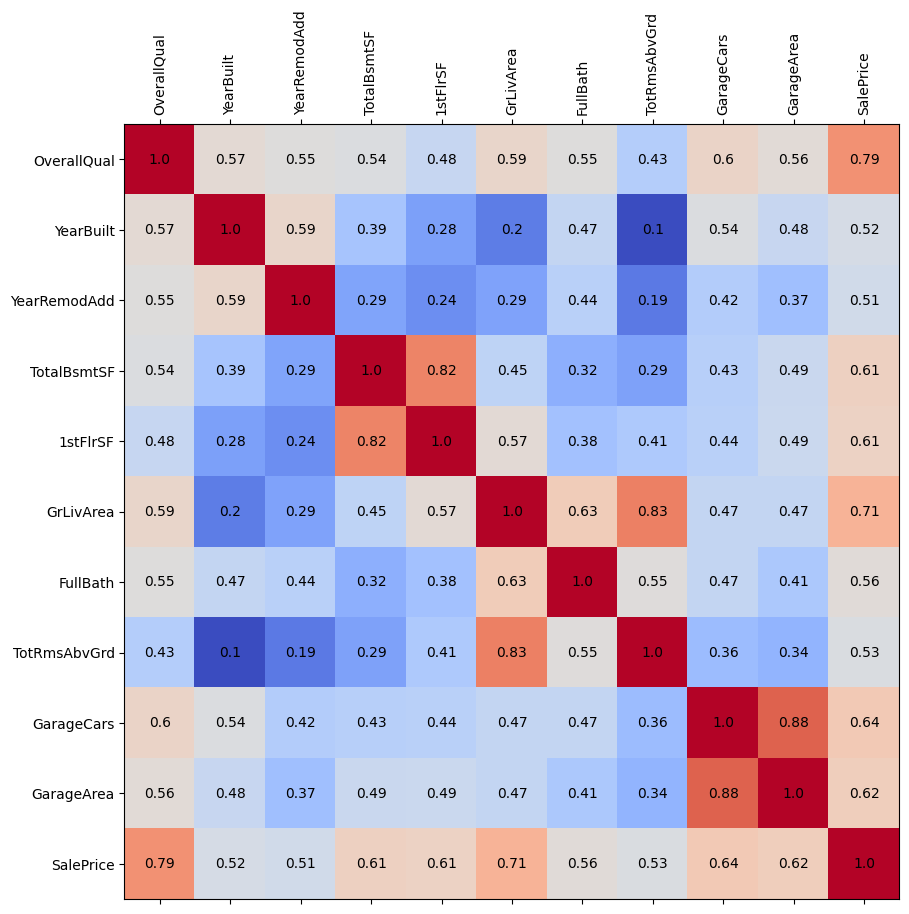

In [95]:
#keep only the features that have a correlation of 0.5 or higher with SalePrice
numeric_corr = numeric_corr['SalePrice']
numeric_corr = numeric_corr[numeric_corr > 0.5]

ajr_correlation_plot(numeric_df[numeric_corr.index].corr())

In [96]:
X = numeric_df.drop(columns=['SalePrice'])
y = numeric_df['SalePrice']

correlation_matrix = numeric_df.corr()
correlated_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > 0.5].index
X = X[correlated_features.drop('SalePrice')]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [97]:
param_grids = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForestRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]},
    'AdaBoostRegressor': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'BaggingRegressor': {'n_estimators': [10, 50, 100]},
    'ExtraTreesRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'DecisionTreeRegressor': {'max_depth': [None, 10, 20]},
    'KNeighborsRegressor': {'n_neighbors': [3, 5, 10]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
}

In [98]:
results = {}
best_models = {}

print('Training models... tuning hyperparameters...')
for name, model in tqdm(models.items()):
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = np.sqrt(-grid_search.best_score_)  # RMSE

    results[name] = best_rmse
    best_models[name] = best_model

Training models... tuning hyperparameters...


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


In [99]:
print('\nModel Performance (RMSE):')
for name, rmse in results.items():
    print(f'{name}: {rmse:.4f}')

print('\nBest Model:')
best_model = best_models[min(results, key=results.get)]
print(f'{best_model}: {results[min(results, key=results.get)]:.4f}')

print(best_model.get_params())


Model Performance (RMSE):
Ridge: 38935.5268
Lasso: 39308.2603
ElasticNet: 38951.8051
RandomForestRegressor: 32956.5904
GradientBoostingRegressor: 33764.6049
AdaBoostRegressor: 37609.2324
BaggingRegressor: 33379.8201
ExtraTreesRegressor: 33017.3889
DecisionTreeRegressor: 42009.0091
KNeighborsRegressor: 34690.0177
SVR: 56760.5186

Best Model:
RandomForestRegressor(n_estimators=200): 32956.5904
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [100]:
feature_importances = zip(X.columns, best_model.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f'{feature}: {importance:.4f}')

OverallQual: 0.5684
GrLivArea: 0.1677
TotalBsmtSF: 0.0636
1stFlrSF: 0.0548
YearBuilt: 0.0355
GarageArea: 0.0335
YearRemodAdd: 0.0272
GarageCars: 0.0243
TotRmsAbvGrd: 0.0135
FullBath: 0.0116


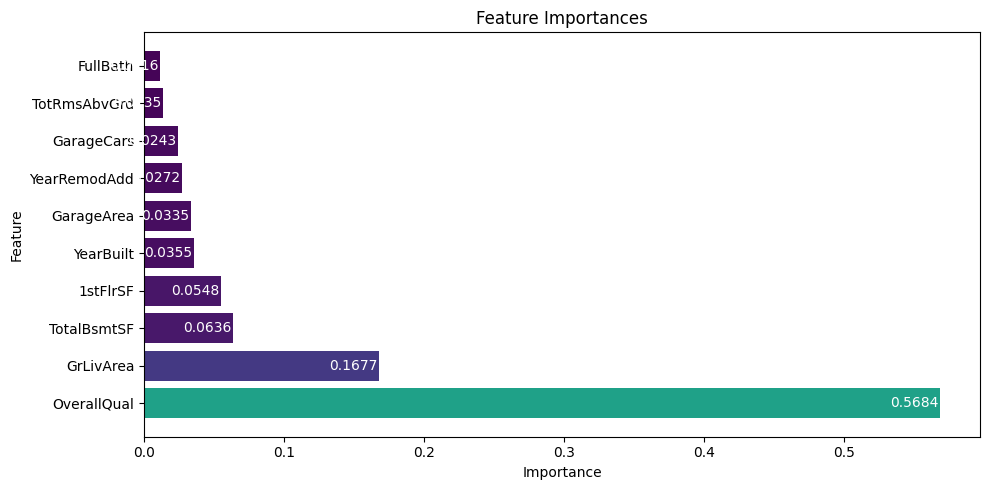

In [101]:
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 5))
    
    colors = cm.viridis([x[1] for x in feature_importances])
    plt.barh([x[0] for x in feature_importances], [x[1] for x in feature_importances], color=colors)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    
    for i, (feature, importance) in enumerate(feature_importances):
        plt.text(importance - 0.001, i, f'{importance:.4f}', ha='right', va='center', color='white')
        
    plt.show()

Total explained variance with selected components: 1.0000
Number of components: 10
Training models with PCA-transformed features...


100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


Model Performance with PCA (RMSE):
Ridge: 39200.5854
Lasso: 39312.0511
ElasticNet: 39197.4943
RandomForestRegressor: 34913.5614
GradientBoostingRegressor: 33541.0254
AdaBoostRegressor: 40256.8596
BaggingRegressor: 35084.2939
ExtraTreesRegressor: 34529.8797
DecisionTreeRegressor: 47261.7347
KNeighborsRegressor: 41501.2511
SVR: 41490.6855

Best Model with PCA:
GradientBoostingRegressor(): 33541.0254
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


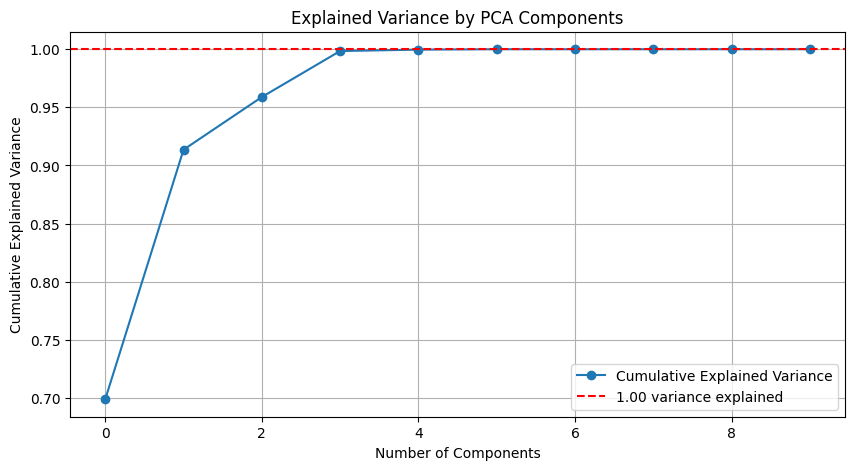

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca= PCA(n_components=10)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f'Total explained variance with selected components: {explained_variance[-1]:.4f}')
print(f'Number of components: {pca.n_components_}')

param_grids = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForestRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]},
    'AdaBoostRegressor': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'BaggingRegressor': {'n_estimators': [10, 50, 100]},
    'ExtraTreesRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'DecisionTreeRegressor': {'max_depth': [None, 10, 20]},
    'KNeighborsRegressor': {'n_neighbors': [3, 5, 10]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
}

results_pca = {}
best_models_pca = {}

print('Training models with PCA-transformed features...')
for name, model in tqdm(models.items()):
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = np.sqrt(-grid_search.best_score_)  # RMSE

    results_pca[name] = best_rmse
    best_models_pca[name] = best_model

print('\nModel Performance with PCA (RMSE):')
for name, rmse in results_pca.items():
    print(f'{name}: {rmse:.4f}')

print('\nBest Model with PCA:')
best_model_pca = best_models_pca[min(results_pca, key=results_pca.get)]
print(f'{best_model_pca}: {results_pca[min(results_pca, key=results_pca.get)]:.4f}')

print(best_model_pca.get_params())

#visualize explained variance
plt.figure(figsize=(10, 5))
plt.plot(explained_variance, marker='o', label="Cumulative Explained Variance")
plt.axhline(y=explained_variance[-1], color='r', linestyle='--', label=f"{explained_variance[-1]:.2f} variance explained")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.legend()
plt.grid()
plt.show()

In [112]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()

param_grid = {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

sfs = SequentialFeatureSelector(
    model,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train, y_train)

X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train_sfs, y_train)
model.fit(X_train_sfs, y_train)

y_pred = model.predict(X_test_sfs)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')
print(f'r2: {r2_score(y_test, y_pred):.4f}')

RMSE: 32346.1424
r2: 0.8636


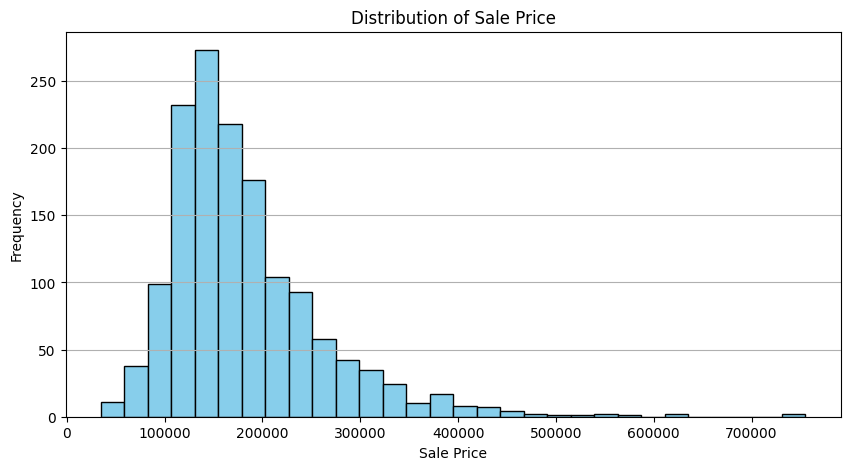

In [113]:
#what is the distribution of saleprice
plt.figure(figsize=(10, 5))
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price')
plt.grid(axis='y')
plt.show()


In [115]:
min_sale_price = y.min()
max_sale_price = y.max()

print(f'Min: {min_sale_price}, Max: {max_sale_price}, Range: {max_sale_price - min_sale_price}')

#rmse as percent of sale range
rmse_percent = rmse / (max_sale_price - min_sale_price) * 100
print(f'RMSE as a percent of the range of Sale Prices: {rmse_percent:.2f}%')

Min: 34900, Max: 755000, Range: 720100
RMSE as a percent of the range of Sale Prices: 4.49%
